In [1]:
#  Step 1: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Optional: Make plots prettier
sns.set(style='whitegrid')


In [2]:
#  Step 2: Load the dataset

# Adjust this path if your dataset is not in the same folder
df = pd.read_csv(r"E:\PROJECT ZIPS FOLDER\train.csv")

# Show basic info
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [3]:
#  Step 3: Check dataset structure

print(df.columns)
print(df.dtypes)

# Preview missing values
print(df.isnull().sum())


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [4]:
#  Step 4: Convert date column & aggregate weekly sales

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate weekly sales across all stores (or adjust logic per store if needed)
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Prophet requires columns: ds (date) and y (target)
weekly_sales.columns = ['ds', 'y']

# Preview data
weekly_sales.head()


,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


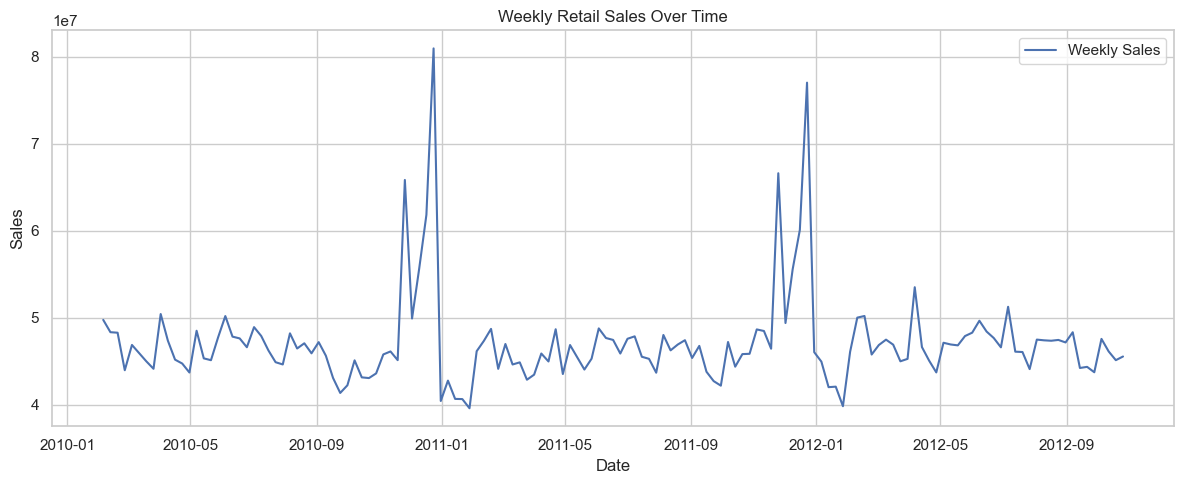

In [5]:
#  Step 5: Plot the time series

plt.figure(figsize=(12, 5))
plt.plot(weekly_sales['ds'], weekly_sales['y'], label='Weekly Sales')
plt.title('Weekly Retail Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
#  Step 6: Build and train the Prophet model

model = Prophet()
model.fit(weekly_sales)


02:09:19 - cmdstanpy - INFO - Chain [1] start processing
02:09:19 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
#  Step 7: Create future dataframe & forecast

# Forecast the next 12 weeks
future = model.make_future_dataframe(periods=12, freq='W')

# Predict future
forecast = model.predict(future)

# Show forecast dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
150,2012-12-16,6.478855e+07,6.029524e+07,6.938128e+07
151,2012-12-23,6.361457e+07,5.903487e+07,6.812897e+07
152,2012-12-30,5.620218e+07,5.183652e+07,6.105110e+07
153,2013-01-06,4.612336e+07,4.152003e+07,5.056456e+07
154,2013-01-13,3.934333e+07,3.508129e+07,4.388291e+07


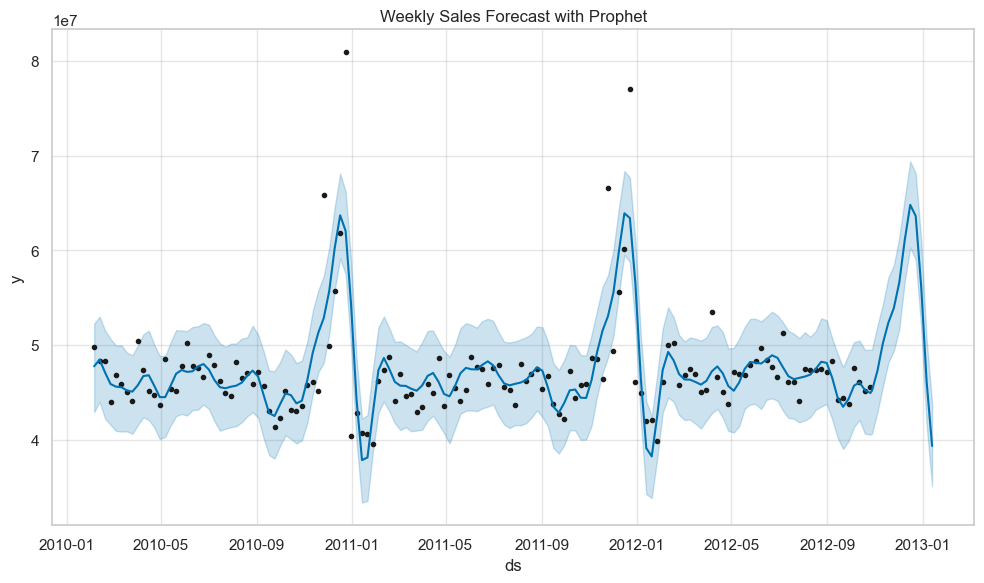

In [8]:
#  Step 8: Plot forecast

fig1 = model.plot(forecast)
plt.title('Weekly Sales Forecast with Prophet')
plt.tight_layout()
plt.show()


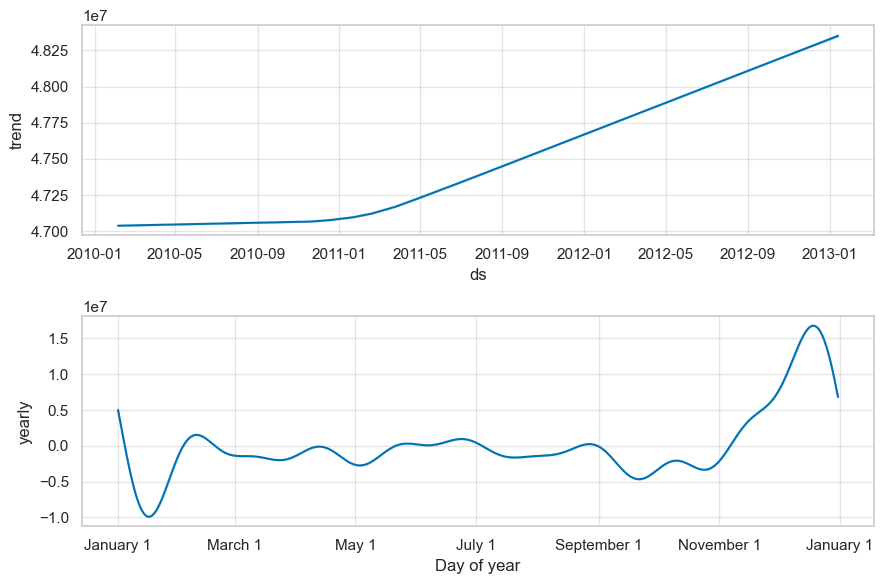

In [9]:
#  Step 9: Plot forecast components (trend, seasonality, holidays if any)

fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()


In [10]:
#  Step 10: Evaluate forecast performance (optional)

# Compare last 12 weeks of actual vs forecast
# Get actual from end of original data
actual = weekly_sales['y'].tail(12).reset_index(drop=True)

# Get predicted from forecast (last 12 rows beyond original dates)
predicted = forecast.tail(12)['yhat'].reset_index(drop=True)

# Mean Absolute Error
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (last 12 weeks): {mae:.2f}")


Mean Absolute Error (last 12 weeks): 8276981.93


#  PHASE 2 — Hybrid Forecasting (Prophet + XGBoost)
Goal: Use Prophet to extract time series features (trend, seasonality), then feed those as features into XGBoost.



In [11]:
# Prepare Data for One Store (Example: Store 1)
#We'll prototype on Store 1, then generalize to all stores later.

import pandas as pd
from prophet import Prophet

# Load the data
df = pd.read_csv(r"E:\PROJECT ZIPS FOLDER\train.csv",parse_dates=["Date"])




store_1 = df[df["Store"] == 1][["Date", "Weekly_Sales"]].rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# Fit Prophet model
model = Prophet()
model.fit(store_1)

# Create future dataframe
future = model.make_future_dataframe(periods=12, freq="W")
forecast = model.predict(future)

# Merge forecast with actuals
df_merged = pd.merge(
    forecast[["ds", "trend", "yhat"]],
    store_1,
    on="ds",
    how="left"
)




02:09:24 - cmdstanpy - INFO - Chain [1] start processing
02:09:24 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
#  Use Prophet to Get Trend Signal

from prophet import Prophet
import pandas as pd

# Load the data
df = pd.read_csv(r"E:\PROJECT ZIPS FOLDER\train.csv", parse_dates=["Date"])

# Focus on Store 1
store_1 = df[df["Store"] == 1][["Date", "Weekly_Sales"]].rename(columns={"Date": "ds", "Weekly_Sales": "y"})

# Fit Prophet
model = Prophet()
model.fit(store_1)

# Forecast 12 future weeks
future = model.make_future_dataframe(periods=12, freq="W")
forecast = model.predict(future)

# Keep only necessary columns
df_prophet = forecast[["ds", "trend", "yhat"]].copy()
df_prophet = pd.merge(df_prophet, store_1, on="ds", how="left")


02:09:27 - cmdstanpy - INFO - Chain [1] start processing
02:09:27 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Feature Engineering for XGBoost
#We’ll:

#Add lag features (e.g., last week’s sales)

#Add rolling means

#Use Prophet’s trend as an input feature


# Add lag and rolling features
df_prophet["y_lag_1"] = df_prophet["y"].shift(1)
df_prophet["y_lag_2"] = df_prophet["y"].shift(2)
df_prophet["rolling_mean_4"] = df_prophet["y"].shift(1).rolling(4).mean()
df_prophet["rolling_std_4"] = df_prophet["y"].shift(1).rolling(4).std()

# Drop rows with NaNs from shifting
df_features = df_prophet.dropna().copy()


In [14]:
# Train/Test Split
#We’ll use the last 12 weeks as the test set, rest for training:

# Sort to ensure order
df_features = df_features.sort_values("ds")

train = df_features[:-12]
test = df_features[-12:]

X_train = train[["trend", "y_lag_1", "y_lag_2", "rolling_mean_4", "rolling_std_4"]]
y_train = train["y"]

X_test = test[["trend", "y_lag_1", "y_lag_2", "rolling_mean_4", "rolling_std_4"]]
y_test = test["y"]


In [15]:
# Train XGboost model:

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Train XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred = model_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f"Hybrid Forecasting MAE (last 12 weeks): {mae:,.2f}")


Hybrid Forecasting MAE (last 12 weeks): 3,354.83


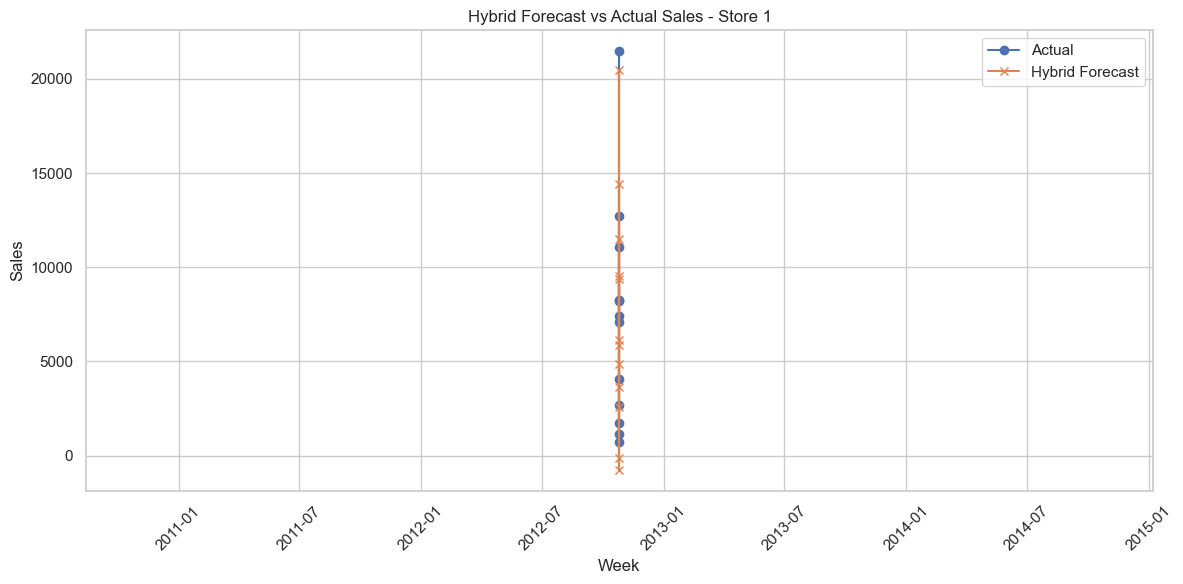

In [16]:
#  Plot Actual vs Predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test["ds"], y_test.values, label="Actual", marker='o')
plt.plot(test["ds"], y_pred, label="Hybrid Forecast", marker='x')
plt.xticks(rotation=45)
plt.title("Hybrid Forecast vs Actual Sales - Store 1")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()
